In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import numpy as np
import torch.utils.data as td
import random
import time
import matplotlib.pyplot as plt

In [3]:
def cifar_loaders(batch_size, shuffle_test=False):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.225, 0.225, 0.225])
    train = datasets.CIFAR10('~/data/cifar10', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomCrop(32, 4),
                                 transforms.ToTensor(),
                                 normalize,
                             ]))
    test = datasets.CIFAR10('~/data/cifar10', train=False,
                            transform=transforms.Compose([transforms.ToTensor(), normalize]))
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size,
                                               shuffle=True, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size,
                                              shuffle=shuffle_test, pin_memory=True)
    return train_loader, test_loader


In [4]:
batch_size = 64
test_batch_size = 64

train_loader, _ = cifar_loaders(batch_size)
_, test_loader = cifar_loaders(test_batch_size)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
for i, (image, labels) in enumerate(train_loader):
    break

In [6]:
type(image), image.shape, labels

(torch.Tensor,
 torch.Size([64, 3, 32, 32]),
 tensor([5, 6, 3, 6, 5, 3, 4, 8, 2, 0, 2, 9, 4, 7, 5, 7, 1, 0, 5, 9, 6, 5, 3, 6,
         1, 3, 2, 8, 4, 3, 9, 3, 1, 5, 7, 1, 5, 6, 2, 5, 5, 4, 9, 9, 8, 5, 5, 0,
         3, 6, 7, 7, 0, 8, 0, 1, 8, 5, 5, 2, 1, 4, 3, 5]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


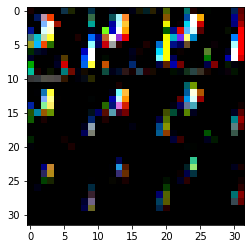

In [7]:
sample_image = image[0]
plt.imshow(sample_image.view(sample_image.shape[2], sample_image.shape[1], sample_image.shape[0]))

In [49]:
from models import MLP, mlp_preprocessing, CNN, cnn_preprocessing
from tqdm import trange
from tqdm.auto import tqdm

In [44]:
mlp = MLP(3*32*32, 10)
cnn = CNN(3*32*32, 10)

In [37]:
t_image = Variable(image.view(-1, 3*32*32))
t_image.shape

torch.Size([64, 3072])

In [43]:
image.reshape(-1, 1024).shape

torch.Size([192, 1024])

In [47]:
cnn(image).shape

torch.Size([64, 10])

In [50]:
device = torch.device(
    'cuda:0') if torch.cuda.is_available() else torch.device('cpu')
loss_fn = torch.nn.CrossEntropyLoss()
opt = optim.Adam(mlp.parameters(), lr=5e-2)
# with trange(3, desc="Training", unit="epoch") as bar:
for epoch in range(1):
    loss_history = []
    with tqdm(train_loader) as bar:
        for i, (images, labels) in enumerate(bar):
            # images = Variable(images.view(-1, 3*32*32)).to(device)
            # labels = labels.to(device)
            images, labels = cnn_preprocessing(images, labels)
            images, labels = images.to(device), labels.to(device)
            ## Prediction
            output = cnn(images)
            loss = loss_fn(output, labels)
            
            predictions = output.argmax(dim=1).squeeze()
            correct = (predictions == labels).sum().item()
            accuracy = correct / images.shape[0]

            loss.backward()
            opt.step()
            opt.zero_grad()

            loss_history.append(loss.cpu().detach().numpy())
            current_total_loss = np.mean(loss_history)
            bar.set_description(f'Train batch {i}')
            bar.set_postfix(batch_loss=loss.item(), total_loss=current_total_loss, accuracy=accuracy)
    
        


Train batch 75:  10%|▉         | 76/782 [00:29<04:38,  2.54it/s, accuracy=0.0781, batch_loss=2.31, total_loss=2.3]


TypeError: int() argument must be a string, a bytes-like object or a number, not 'Image'

In [16]:
output.argmax(dim=1).squeeze()

torch.Size([16])

In [14]:
labels.shape

torch.Size([16])